In [1]:
import pandas as pd
import torch
import torch.nn as nn

In [2]:
df = pd.read_csv('../output.csv')

In [3]:
df.head()

,s,o,h,l,c,v,t
0,ok,173.26,173.26,173.26,173.26,0.0,869356800
1,ok,173.25,173.25,173.25,173.25,0.0,869443200
2,ok,173.03,173.03,173.03,173.03,0.0,869529600
3,ok,173.03,173.03,173.03,173.03,0.0,869616000
4,ok,172.66,172.66,172.66,172.66,0.0,869702400


In [4]:
df.shape

(6329, 7)

In [5]:
df.columns

Index(['s', 'o', 'h', 'l', 'c', 'v', 't'], dtype='object')

In [6]:
df= df.rename(columns={'s':'s',"o":'opening_price','h':'high_price','l':'lowest_price','c':'closing_price','v':'volume','t':'timestamp'})
df.head()

,s,opening_price,high_price,lowest_price,closing_price,volume,timestamp
0,ok,173.26,173.26,173.26,173.26,0.0,869356800
1,ok,173.25,173.25,173.25,173.25,0.0,869443200
2,ok,173.03,173.03,173.03,173.03,0.0,869529600
3,ok,173.03,173.03,173.03,173.03,0.0,869616000
4,ok,172.66,172.66,172.66,172.66,0.0,869702400


In [7]:
df.drop(['s'],axis = 1,inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6329 entries, 0 to 6328
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   opening_price  6329 non-null   float64
 1   high_price     6329 non-null   float64
 2   lowest_price   6329 non-null   float64
 3   closing_price  6329 non-null   float64
 4   volume         6329 non-null   float64
 5   timestamp      6329 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 296.8 KB


In [9]:
df.describe()

,opening_price,high_price,lowest_price,closing_price,volume,timestamp
count,6329.000000,6329.000000,6329.000000,6329.000000,6.329000e+03,6.329000e+03
mean,944.901435,949.804121,939.267383,944.162002,1.031748e+09,1.314714e+09
std,778.576378,785.827006,769.801524,777.129855,2.667614e+09,2.546312e+08
min,156.430000,156.430000,156.430000,156.430000,0.000000e+00,8.693568e+08
25%,313.000000,313.000000,313.000000,313.000000,0.000000e+00,1.093392e+09
50%,634.000000,634.000000,634.000000,634.000000,0.000000e+00,1.316045e+09
75%,1391.030000,1402.210000,1382.330000,1391.030000,5.158190e+08,1.534637e+09
max,3208.530000,3227.110000,3178.250000,3198.190000,2.995852e+10,1.752106e+09


In [10]:
df['volume'] = df['volume'].astype('int64')

In [11]:
df.timestamp = pd.to_datetime(df.timestamp, unit='s')#.dt.tz_localize("Asia/Kathmandu")

In [12]:
df.timestamp

0      1997-07-20
1      1997-07-21
2      1997-07-22
3      1997-07-23
4      1997-07-24
          ...    
6324   2025-07-06
6325   2025-07-07
6326   2025-07-08
6327   2025-07-09
6328   2025-07-10
Name: timestamp, Length: 6329, dtype: datetime64[ns]

In [13]:
df = df.set_index('timestamp')

In [14]:
df.tail()

,opening_price,high_price,lowest_price,closing_price,volume
timestamp,,,,,
2025-07-06,2708.24,2722.33,2697.32,2706.36,9500003268
2025-07-07,2715.40,2718.10,2680.45,2684.01,8377327147
2025-07-08,2683.77,2690.13,2662.59,2683.86,6574166814
2025-07-09,2679.37,2707.91,2679.16,2705.90,7451877102
2025-07-10,2709.09,2743.09,2706.89,2731.80,9682488739


In [15]:
df.isnull().sum()

opening_price    0
high_price       0
lowest_price     0
closing_price    0
volume           0
dtype: int64

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Select the column you want to predict (typically 'Close' price)
prices = df['closing_price'].values.reshape(-1, 1)

# Normalize the data (critical for neural networks)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [17]:
# Splitting dataset into training set and test set
train_size = int(len(scaled_prices)*0.65)
test_size = len(scaled_prices)-train_size
train_data,test_data = scaled_prices[0:train_size,:],scaled_prices[train_size:len(scaled_prices),:1]


In [18]:
def create_sequences(data, window_size=3):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append(seq)
        targets.append(label)
    return torch.FloatTensor(sequences), torch.FloatTensor(targets)

window_size = 7  # Can iterate over 3 to 5 for experiments
X_train, y_train = create_sequences(train_data, window_size)
X_test,y_test = create_sequences(test_data,window_size)


/tmp/ipykernel_8014/3340240768.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.FloatTensor(sequences), torch.FloatTensor(targets)


In [19]:
import torch
import torch.nn as nn

class StockPredictorLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [20]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Initialize model
model = StockPredictorLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [21]:
# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0174
Epoch [20/100], Loss: 0.0066
Epoch [30/100], Loss: 0.0073
Epoch [40/100], Loss: 0.0060
Epoch [50/100], Loss: 0.0057
Epoch [60/100], Loss: 0.0050
Epoch [70/100], Loss: 0.0044
Epoch [80/100], Loss: 0.0035
Epoch [90/100], Loss: 0.0022
Epoch [100/100], Loss: 0.0007


In [22]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Inverse transform to get actual prices
    predicted_prices = scaler.inverse_transform(test_outputs.numpy())
    actual_prices = scaler.inverse_transform(y_test_tensor.numpy())

Test Loss: 0.0015


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 105.47
Mean Squared Error (MSE): 13981.65
Root Mean Squared Error (RMSE): 118.24
R^2 Score: 0.9559
Mean Absolute Percentage Error (MAPE): 6.67%


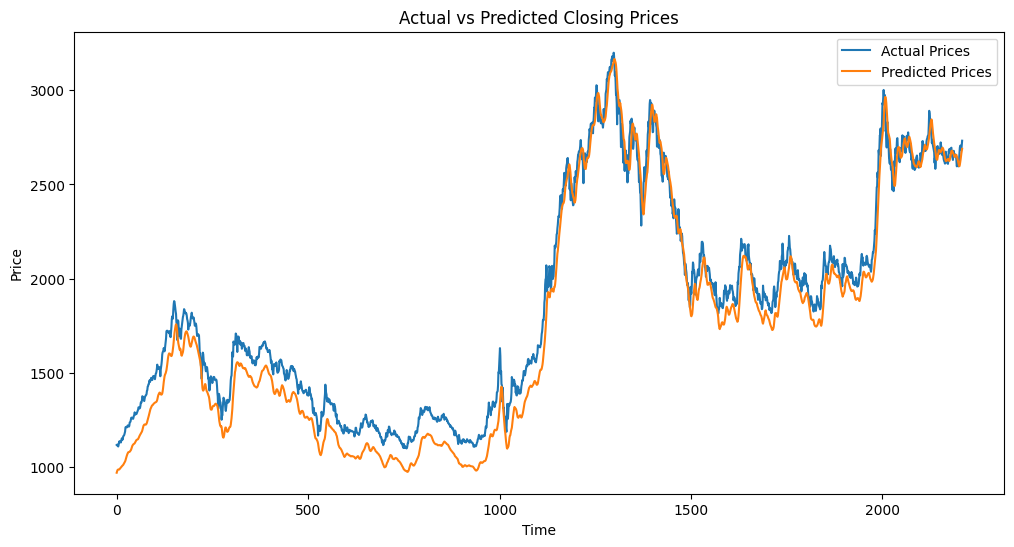

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
def predict_next_day(model, last_sequence, scaler):
    model.eval()
    with torch.no_grad():
        last_sequence_tensor = torch.FloatTensor(last_sequence)
        prediction = model(last_sequence_tensor)
        predicted_price = scaler.inverse_transform(prediction.numpy())
    return predicted_price[0][0]

# Get the last sequence from your data
last_sequence = scaled_prices[-window_size:].reshape(1, window_size, 1)
next_day_prediction = predict_next_day(model, last_sequence, scaler)
print(f"Predicted price for next day: {next_day_prediction:.2f}")

Predicted price for next day: 2698.51
